# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

from geo_annulus import *
#from multipatch_block_handler import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
 no MKL


In [2]:
# 3 D #
p = 3 # spline degree
multi= 2
n_el = (4, 2, 2)  # number of elements in x, y, z direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo, grid=10, gridx=None, gridy=None, gridz= None,
             res=30,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    #print("geo.sdim:", geo.sdim)
    #print("geo.dim:", geo.dim)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
            #print(gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        #print(meshx)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


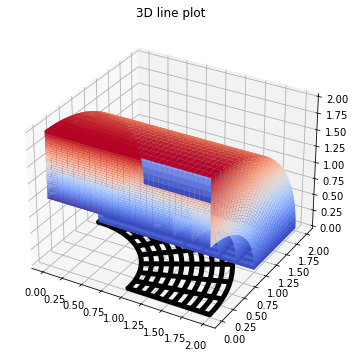

In [4]:
G = geometry.tensor_product(geometry.quarter_annulus(), geometry.line_segment(0,2))
G2 =  geometry.quarter_annulus()
#G = geometry.tensor_product(geometry.line_segment(0,1), geometry.quarter_annulus())
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')
plot_geo(G) #vmin=0.0, vmax=2.5e-2 3D

plot_geo(G2, linewidth=5) #vmin=0.0, vmax=2.5e-2 2D
ax.set_title('3D line plot')
plt.show()

In [5]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4.5
r_in = 3.7

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]


# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,1), g) for g in geos]
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,5)) for g in geos]

In [6]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

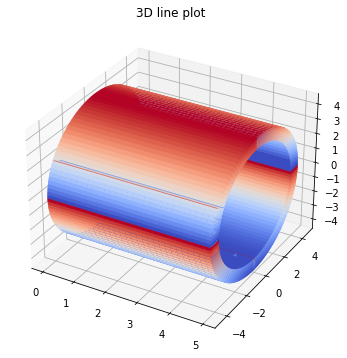

In [7]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

for g in geos_3d:
    plot_geo(g)#, vmin=0, vmax=7.5)

ax.set_title('3D line plot')
plt.show()

In [8]:
# define boundary conditions

In [9]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [10]:
#Neumann BC
def gN0(x, y, z): 
#quarter annulus in y/z coord.system
    #xx= linspace(0,1,10)
    #for i in range(len(xx)):
    return (0, y/r_in*l_val, z/r_in*l_val) # inner pressure, in normal direction (0, 1, 1)

# quarter annulus in x/y coord.system
   # return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector
# normal direction in z does not exist by now!


In [11]:
def g0(x,y,z): #different load over x-axis
    if (x > 1.5).all() and (x < 3.5).all():
        #print(x)
        return l_val # set force at middle only
    else:
        return 0

In [12]:
def gN(x, y, z): #different load over x-axis
    if isinstance(x,numpy.float64):
        return (0, 0, 0)
    s_y = shape(y)
    fac = [g0(xi,y, z) for xi in np.nditer(x)]
    fac= np.reshape(fac, s_y)
    return (0, y/r_in* fac, z/r_in*fac)# inner pressure

In [13]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [14]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [15]:
# Compute solution of nonlinear elasticity problem

In [16]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [17]:
M = ass_mass3d(MP_block)
Minv = make_solver(M)

use SuperLU


In [18]:
#incremental loading
maxload = 6e-4 #3e-2#1.5e-3 # for Dirichlet #2e-3# for Robin
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [19]:
# No Robin-bdc
robin_data = None

In [20]:
def J(u):
    return ass_energy3d(u, MP_block, kvs_j, neu_data)


def grad_J(u):
    return -ass_rhs3d(u, MP_block, neu_data)

# TODO: It is inefficient to:
#           (i)   compute A if only grad_J is used,
#           (ii)  compute A and/or b repeatedly for the same u,
#           (iii) recompute the vector from the Neumann conditions for rhs (term needs re-scaling for changes of scaling),
#           (iv)  recompute the Robin matrix.
# Further impovement possible by using "updatable" field as in the solve-navier-stokes example.

In [21]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    
### first iteration ###
A, b = ass_nonlinsystem3d(u, MP_block, neu_data) # without Robin-matrix

LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0 = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

# new solution
A, b = ass_nonlinsystem3d(u, MP_block, neu_data) # without Robin-matrix
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))

###-----------------###--------------------###
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
#get_defplot3d(u, patches_u, kvs_u, MP_u, n_el)

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\moda7381a42bdfc2643.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\moda7381a42bdfc2643.pyx


Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb5b8bc8887cba5f5.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb5b8bc8887cba5f5.pyx
Residual0 = 0.0014428043993394734
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod339c772353e5934a.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod339c772353e5934a.pyx
Energy0   = 0.0
use SuperLU
Residual  = 0.5820987170603653
Energy    = 0.024744864196520215


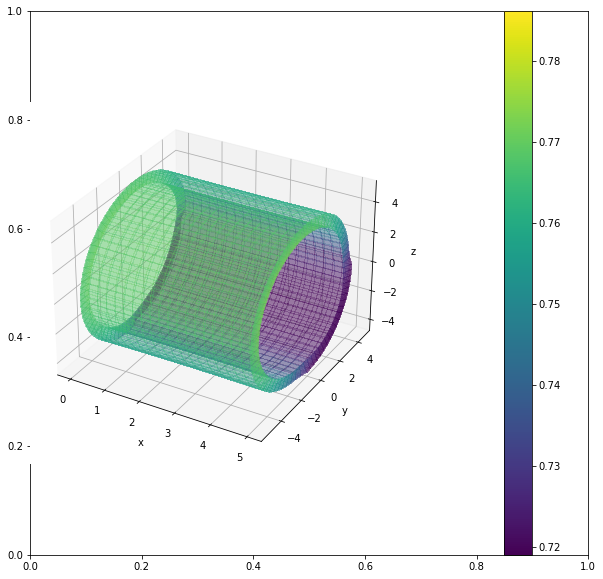

In [22]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [25]:
def get_defplotpp(u, patches_u, kvs_u, MP_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    
    #u= LS.complete(u)
    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)
    
    fig, ax = plt.subplots(figsize= (10,10))
    #ax = plt.axes(projection ='3d')
    vrange = None
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    
    count=0
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        print('\n patch:', count)
        
        #res= x_el

        #if gridx is None: gridx = grid
        #if gridy is None: gridy = grid
        if gridz is None: gridz= 1# grid # = 1# grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        #if np.isscalar(gridx):
            #gridx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 10)
        #if np.isscalar(gridy):
            #gridy = np.linspace(supp[1][0], supp[1][1], res)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        #meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            #print(shape(C))
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            print(shape(pts))
            
            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
            
            plt.plot(pts[0,0, 1], pts[0,0, 2], 'ro') # inner radius
            plt.plot(pts[0,res-1, 1], pts[0,res-1, 2], 'bo') # outer radius
            radius_inner = np.sqrt( (pts[0,0, 1])**2 + (pts[0,0, 2])**2)
            print('inner_radius: ', radius_inner)
            #plt.plot(pts[z_el-1,0, 1], pts[z_el-1,0, 2], 'bo') # inner radius
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
        
        #xgridyz = (gridx,gridx, gridx)
        #ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)


         # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        print('dis=',shape(dis))
        #print('dis3=', shape(dis3))
        print('displacement_inner= {}'.format(dis[0, 0,...]))
        #print('displacement_y= {}'.format(dis[...,1]))
        #print('displacement_21= {}'.format(dis2[...,0]))
        dis23= np.stack((dis2[...,0], dis3[...,0]), axis=-1) # displacement(y,z) evaluated on 3-dim grid, reduced to 2d 
        #print('displacement_23= {}'.format(dis23))
        #print('first: ',dis23[0,0, 0])#inner y
        #print('second: ',dis23[0,0, 1])# innerz
        #print('first2: ',dis23[0,res-1, 0])# outer y
        #print('second2: ',dis23[0,res-1, 1])# outer z
        #print('displacement_z= {}'.format(dis[...,2]))
        #print('displacement_inner= {}'.format(dis[0,0,0]))
        #print('displacement_inner= {}'.format(dis))
        #print('displacement_outer= {}'.format(dis[0, res-1,...]))
        #print('displacement_outer= {}'.format(dis[0,0,0]))
         #plt.plot(G[i, 0, 0] + dis[0,0, 0], G[i, 0, 1] + dis2[i, 0], 'ro') # inner radius
        

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
       
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
             
        G= grid_eval(geo, zgridxy)
        print('G=',shape(G))
        #print(G)
        G23= np.stack((G[...,1], G[...,2]), axis=-1) # displacement(y,z) evaluated on 3-dim grid, reduced to 2d 
        #print(G23)
        #print(shape(G23))
        #print('firstG:', G23[0,0,0,0])
        #print('secondG:', G23[0,0,0,1])
        #print('firstG3:', G[0,0,0, 1])
        #print('secondG3:', G[0,0,0, 2])
        
        #print('first2G:', G23[0,res-1,0,0])
        #print('second2G:', G23[0,res-1,0,1])
        plt.plot(G[0,0,0, 1], G[0,0,0, 2], 'mo') # inner radius
        plt.plot(G[0,res-1,0, 1], G[0,res-1,0, 2], 'go') # outer radius
        #plt.plot(G[0,0,0, 1] +dis2[0,0,0], G[0,0,0, 2]+dis3[0,0,0], 'mo') # inner radius
        #plt.plot(G[0,res-1,0, 1]+dis2[0,0,0], G[0,res-1,0, 2]+dis3[0,0,0], 'go') # outer radius
        
        ### need for data export!!
        #print( 'dis_inner_y/dis_outer_y: ', dis2[0,0,0]/dis2[0,res-1,0])
        print( 'dis_inner_y/dis_outer_y: ', dis23[0,0, 0]/dis23[0,res-1, 0])
        print( 'dis_inner_z/dis_outer_z: ', dis3[0,0,0]/dis3[0,res-1,0])
        #print( 'dis_inner_z/dis_outer_z: ', dis23[0,0, 1]/dis23[0,res-1, 1])
        
        #radius_inner2 = np.sqrt( (G[0,0,0, 1] +dis2[0,0,0])**2 + (G[0,0,0, 2]+dis3[0,0,0])**2)
        #print('inner_radius_2: ', radius_inner2)
        radius_inner3 = np.sqrt( (G[0,0,0, 1] +dis23[0,0, 0])**2 + (G[0,0,0, 2]+dis23[0,0, 1])**2)
        print('inner_radius_3: ', radius_inner3)
        
        count+=1
        
        
        
    #C = np.sqrt( np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    #C = np.sqrt( np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    #vrange = (C.min(), C.max())
    #vrange = (0, 1.5e-5)
    #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
   
    
    plt.colorbar();
    plt.axis('equal')
    #ax.set_xlabel("x")
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    
    plt.show()


 patch: 0
dis= (20, 20, 2, 3)
displacement_inner= [[ 0.061656    0.07718099  0.16707283]
 [-0.061656    0.07718099  0.16707283]]
(20, 20, 3)
inner_radius:  3.7808741839786357
(20, 20, 3)
inner_radius:  3.7808741839786926
G= (20, 20, 2, 3)
dis_inner_y/dis_outer_y:  inf
dis_inner_z/dis_outer_z:  inf
inner_radius_3:  3.7808741839786357

 patch: 1
dis= (20, 20, 2, 3)
displacement_inner= [[ 0.061656   -0.16707283 -0.07718099]
 [-0.061656   -0.16707283 -0.07718099]]
(20, 20, 3)
inner_radius:  3.7808741839787214
(20, 20, 3)
inner_radius:  3.7808741839786806
G= (20, 20, 2, 3)
dis_inner_y/dis_outer_y:  -inf
dis_inner_z/dis_outer_z:  -inf
inner_radius_3:  3.7808741839787214

 patch: 2
dis= (20, 20, 2, 3)
displacement_inner= [[ 0.13520383 -0.74418517  0.15575563]
 [-0.13520383 -0.74418517  0.15575563]]
(20, 20, 3)
inner_radius:  4.446913718906138
(20, 20, 3)
inner_radius:  4.446913718905267
G= (20, 20, 2, 3)
dis_inner_y/dis_outer_y:  1.085398464957309
dis_inner_z/dis_outer_z:  0.9324884586180336

C:\Users\MHeig\AppData\Local\Temp\ipykernel_4200\2795196996.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  print( 'dis_inner_y/dis_outer_y: ', dis23[0,0, 0]/dis23[0,res-1, 0])
C:\Users\MHeig\AppData\Local\Temp\ipykernel_4200\2795196996.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  print( 'dis_inner_z/dis_outer_z: ', dis3[0,0,0]/dis3[0,res-1,0])


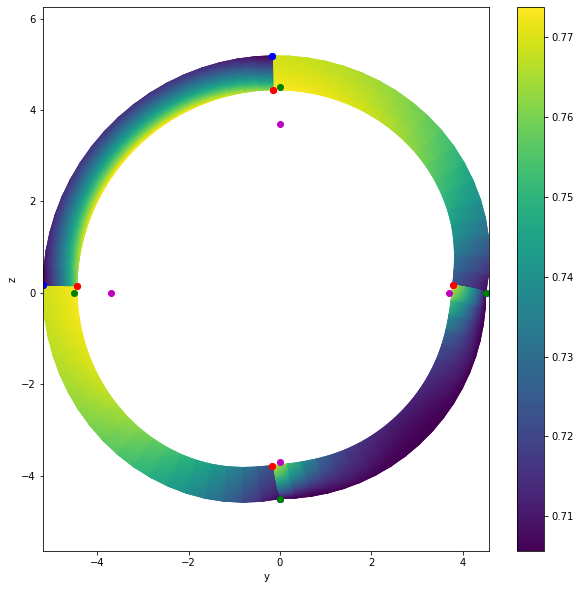

In [26]:
get_defplotpp(u, patches_u, kvs_u, MP_u)

In [ ]:
# Line search based on energy + line search
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

# residuum for max. loadig
A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0 = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    count= 0
    
    while True:
        count+=1
        if count == 1:
            # first residuum for incremental loading
            A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
            LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
            rhs= LS.complete(LS.b)
            r = np.transpose(rhs).dot(Minv.dot(rhs)) #Dual of L2-norm
            print('Residual =',r)
            print('Energy   =',J(u))
        print(count)

        u_d = make_solver(LS.A).dot(LS.b)  #A+AR

       
        # complete system dependent solution
        u_d = LS.complete(u_d)
        #print( 'grad_k*p_k=',  np.dot(grad_J(u), u_d))            
        u += u_d       
            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system (*) use for next iteration
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #Dual of L2-norm
        print('residual = {}'.format(r))
        J0 = J(u)
        print('energy   = {}'.format(J0))
        
        #w1 = np.abs(make_solver(LS.A).dot(LS.b)-LS.restrict(u))        #TODO: We do not want to solve that often!!
        #w2 = np.abs(LS.b - LS.A.dot(LS.restrict(u)))
        #err= np.sqrt(np.inner(w1,w2))
        #print('Error=', err)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du =normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplotC(u, patches_u, kvs_u, MP_u)
#print("done")

In [ ]:
s_cts= shape(iter_counts)[0]

In [ ]:
s_sol= shape(solutions)[0]

In [ ]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field_3d(fields, patches_u, kvs_u, vrange=None, res=50,cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
    
    fields = list(fields)
    ar= np.linspace(1,20, s_sol)
    factor = 1 #ar[0]
    vrange = None
    
    # first solution
    u= LS.complete(fields[0])
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    def plotlineC(pts, C, capstyle='butt'):
                vrange = (C.min(), C.max())
                norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
                ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])

            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
            
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
      
        #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])
        
        
        
        ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid  
        
        #vrange = (C.min(), np.amax(dis[0, 0,...]))

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
    vrange = (C.min(), np.amax(dis[0, 0,...]))
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
  
    #fig.colorbar(quadmesh, ax=ax);
    #colorbar();
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    
    ax.set_xlim3d(left=0, right=5.5)
    ax.set_ylim3d(bottom=-7, top=4.5)
    #ax.set_zlim3d(bottom=-0.5, top=0.5)
    ax.set_zbound(lower=-5.5, upper=5.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    def anim_func(i):
        plt.cla()
        
        vrange= None
        #factor = ar[i] # choose factor for deformation plot
        #u= fields[i]
        u = LS.complete(fields[i])

        #Split solution vector into displacement components
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:2*MP_u.numdofs]
        u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

        # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]
        u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
               for p in range(len(patches_u))]
        
             # visualization per patch
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

            # y-grid 
            dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(ygridxz) #y-value
            dis3 = u3_func.grid_eval(ygridxz) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
            #print('displacement_inner= {}'.format(dis[0, 0,...]))
            print( 'max_val: ', np.amax(dis[0, 0,...]))
            
            

            pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
            #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, 0, :], C[:, 0, :])
            for j in range(1, pts.shape[1] - 1):
                plotlineC(pts[:, j, :], C[:, j, :])
            plotlineC(pts[:, -1, :], C[:, -1, :])

            # z-grid
            dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(zgridxy) #y-value
            dis3 = u3_func.grid_eval(zgridxy) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            #vrange = (C.min(), C.max())
            #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])

            pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
            C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            
            #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, :, 0],C[:, :, 0])
            for k in range(1, pts.shape[2] - 1): 
                plotlineC(pts[:, :, k], C[:, :, k])
            plotlineC(pts[:, :, -1], C[:, :, -1])
        
        pbar.update()
        if i == len(u) - 1:
            pbar.close()

            #
    #vrange = (C.min(), np.amax(dis[0, 0,...]))
    #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    #cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
    
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)
    


In [ ]:
from IPython.display import HTML

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)] ## time steps
HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=535, progress=True).to_html5_video())
#writervideo = animation.FFMpegWriter(fps=15)
#HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=600, progress=True).save('Dir3dc1.mp4', writer=writervideo))

In [ ]:
get_defplotpp(u, patches_u, kvs_u, MP_u)

In [ ]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [ ]:
# Line search based on energy + line search
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

# residuum for max. loadig
A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0 = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

J0 = 0

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    count= 0
    rejected = False
    
    while True:
        count+=1
        if count == 1:
            # first residuum for incremental loading
            A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
            LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
            rhs= LS.complete(LS.b)
            r = np.transpose(rhs).dot(Minv.dot(rhs)) #Dual of L2-norm
            print('Residual =',r)
            print('Energy   =',J(u))
        print(count)

        u_d = make_solver(LS.A).dot(LS.b)  #A+AR

        sp = LS.b.dot(LS.A@u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = LS.b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
            
        # complete system dependent solution
        u_d = LS.complete(u_d)
        #print( 'grad_k*p_k=',  np.dot(grad_J(u), u_d))

        # # do Wolfe-Powell line search # # 
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        print('alpha=', alpha)
        
        if alpha == None:           
            print('Use line search based on energy:')
            alpha = 1.
            J1 = J(u+alpha*u_d)
            print("alpha = {} gives energy {}".format(alpha, J1))
            downfactor = .7
            upfactor   = 1.3

            while J1>J0:
                alpha *= downfactor
                J1 = J(u+alpha*u_d)
                print("alpha = {} gives energy {}".format(alpha, J1))
            if alpha == 1.:
                J2 = J(u+upfactor*alpha*u_d)
                print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
                while J2<J1:
                    alpha *= upfactor
                    J1 = J2
                    J2 = J(u+upfactor*alpha*u_d)
                    print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
            print("alpha = {}".format(alpha))
            
        u += alpha * u_d       
            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system (*) use for next iteration
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #Dual of L2-norm
        print('residual = {}'.format(r))
        J0 = J(u)
        print('energy   = {}'.format(J0))
        
        #w1 = np.abs(make_solver(LS.A).dot(LS.b)-LS.restrict(u))        #TODO: We do not want to solve that often!!
        #w2 = np.abs(LS.b - LS.A.dot(LS.restrict(u)))
        #err= np.sqrt(np.inner(w1,w2))
        #print('Error=', err)


        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot3d(u, patches_u, kvs_u, MP_u, n_el)
print("done")

In [ ]:
# Line search based on energy + line search
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann

# residuum for max. loadig
A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0 = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

J0 = 0

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann

    count= 0
    rejected = False
    
    while True:
        count+=1
        if count == 1:
            # first residuum for incremental loading
            A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
            LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
            rhs= LS.complete(LS.b)
            r = np.transpose(rhs).dot(Minv.dot(rhs)) #Dual of L2-norm
            print('Residual =',r)
            print('Energy   =',J(u))
        print(count)

        u_d = make_solver(LS.A).dot(LS.b)  #A+AR

        sp = LS.b.dot(LS.A@u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = LS.b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
            
        # complete system dependent solution
        u_d = LS.complete(u_d)
        #print( 'grad_k*p_k=',  np.dot(grad_J(u), u_d))

        # # do Wolfe-Powell line search # # 
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        print('alpha=', alpha)
        
        if alpha == None:           
            print('Use line search based on energy:')
            alpha = 1.
            J1 = J(u+alpha*u_d)
            print("alpha = {} gives energy {}".format(alpha, J1))
            downfactor = .7
            upfactor   = 1.3

            while J1>J0:
                alpha *= downfactor
                J1 = J(u+alpha*u_d)
                print("alpha = {} gives energy {}".format(alpha, J1))
            if alpha == 1.:
                J2 = J(u+upfactor*alpha*u_d)
                print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
                while J2<J1:
                    alpha *= upfactor
                    J1 = J2
                    J2 = J(u+upfactor*alpha*u_d)
                    print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
            print("alpha = {}".format(alpha))
            
        u += alpha * u_d       
            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system (*) use for next iteration
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #Dual of L2-norm
        print('residual = {}'.format(r))
        J0 = J(u)
        print('energy   = {}'.format(J0))
        
        #w1 = np.abs(make_solver(LS.A).dot(LS.b)-LS.restrict(u))        #TODO: We do not want to solve that often!!
        #w2 = np.abs(LS.b - LS.A.dot(LS.restrict(u)))
        #err= np.sqrt(np.inner(w1,w2))
        #print('Error=', err)


        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot3d(u, patches_u, kvs_u, MP_u, n_el)
print("done")

In [ ]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [ ]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [ ]:
s_cts= shape(iter_counts)[0]

In [ ]:
s_sol= shape(solutions)[0]

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field_3d(fields, patches_u, kvs_u, vrange=None, res=50,cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
    
    fields = list(fields)
    ar= np.linspace(1,20, s_sol)
    factor = ar[0]
    vrange = None

    # first solution
    u= LS.complete(fields[0])
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    def plotline(pts, capstyle='butt'):
            C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            vrange = (C.min(), C.max())
            ax.plot_surface(factor*pts[..., 0], factor*pts[..., 1], factor*pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3, facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            ax.set_xlim3d(left=0, right=1.5)
            ax.set_ylim3d(bottom=-0.5, top=0.5)
            #ax.set_zlim3d(bottom=-0.5, top=0.5)
            ax.set_zbound(lower=-0.5, upper=0.5)
            
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
      
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        vrange = (C.min(), C.max())
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')
        
        ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1],capstyle='round')
    
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
  
    #fig.colorbar(quadmesh, ax=ax);
    #colorbar();
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    def anim_func(i):
        plt.cla()
        
        vrange= None
        factor = ar[i] # choose factor for deformation plot
        u = LS.complete(fields[i])

        #Split solution vector into displacement components
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:2*MP_u.numdofs]
        u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

        # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]
        u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
               for p in range(len(patches_u))]
        
             # visualization per patch
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

            # y-grid 
            dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(ygridxz) #y-value
            dis3 = u3_func.grid_eval(ygridxz) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid

            C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

            pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
            plotline(pts[:, 0, :], capstyle='round')
            for j in range(1, pts.shape[1] - 1):
                plotline(pts[:, j, :])
            plotline(pts[:, -1, :], capstyle='round')

            # z-grid
            dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(zgridxy) #y-value
            dis3 = u3_func.grid_eval(zgridxy) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            #vrange = (C.min(), C.max())
            #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])

            pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
            plotline(pts[:, :, 0], capstyle='round')
            for k in range(1, pts.shape[2] - 1): 
                plotline(pts[:, :, k])
            plotline(pts[:, :, -1],capstyle='round')
        
            pbar.update()
            if i == len(u) - 1:
                pbar.close()
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)

In [ ]:
from IPython.display import HTML

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)] ## time steps
HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=535, progress=True).to_html5_video())

In [ ]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch , 2D only!
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import LinearLocator
from matplotlib import cm
### 3d surface

def get_defplotC(u, patches_u, kvs_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    
    #u= LS.complete(u)
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    figsize(10,10)
    #fig, ax = plt.subplots()
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    vrange = None
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            #print(shape(C))
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
        
        #xgridyz = (gridx , meshy, meshz)
        xgridyz = (gridx,gridx, gridx)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
    
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
    
        #C = np.sqrt( np.power(dis[..., 0], 2)+np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
        #C = C[:, 0, :]
      
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])

        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
        #C = C[:, :, 0]
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
    #C = np.sqrt( np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    #C = np.sqrt( np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    vrange = (C.min(), C.max())
    #vrange = (0, 1.5e-5)
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    plt.show()

In [ ]:
# print deformation plot
get_defplotC(u, patches_u, kvs_u)